Changes I have made:
1. Changed the lstsq implementation after reading the documentation, and digitize the corrupted signal before using lstsq
2. Moved the header to the middle of the packet for least square estimation
3. Determined Doppler frequency and Packet length using other parameters: velocity, coherence time
4. Created multiple channels with the same transmitted signal but different sampling of the same Jakes envelope

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
import math

In [48]:
# Signal and channel initialization
Fs = 10000  # Sampling frequency
Fc = 1e9    # Carrier frequency
Fd = 100    # Doppler frequency
Tc = 1 / (7*Fd)  # Coherence time (based on Doppler frequency)
N = 100000  # Number of data points in the signal
M = 3  # Number of different channel values (multi-path)
packet_size = math.floor(Fs*Tc)  # Size of each packet
noise_level = 1/10  # Noise level (1/SNR, dB value = 10*log10(SNR))
header_packet_size = math.floor((1/6) * packet_size)  # Known part of the signal

In [50]:
# Generate random digital signal
def generate_digital_signal(length):
    return np.random.choice([-1, 1], size=length)

In [72]:
# Jakes filter implementation
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

# Generate Rayleigh envelope using Jakes model
def generate_rayleigh_envelope(signal_length, velocity, carrier_frequency):
    c = 3e8  # Speed of light in m/s
    fd = velocity * carrier_frequency / c
    Fs = 10000  # Sampling frequency
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N)
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h)
    return np.array(y[500:500 + signal_length])

In [74]:
# Function to digitize the signal
def digitize(signal):
    output_signal = np.zeros_like(signal)
    for i, data in enumerate(signal):
        output_signal[i] = 1 if data >= 0 else -1
    return output_signal

In [76]:
# Initialize channel values using the Jakes model
channel_values = np.array([generate_rayleigh_envelope(N, 30, Fc) for _ in range(M)])


In [78]:
# Packet-wise processing
signal = generate_digital_signal(N)
cleaned_results = [np.zeros(len(signal)) for _ in range(M)]
scaled_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]
noisy_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]

header_error = np.zeros(M)
header_bit_count = np.zeros(M)
header_wrong_count = np.zeros(M)
num = np.zeros(M)

In [80]:
for packet_start in range(0, len(signal), packet_size):
    packet_end = min(packet_start + packet_size, len(signal))
    current_signal = signal[packet_start:packet_end]
    current_channel_values = channel_values[:, packet_start:packet_end]

    for i in range(M):
        scaled = current_signal * current_channel_values[i]
        average_signal_power = np.mean(scaled**2)
        #Do we have to do the per packet power scaling or the entire signal is fine
        #How to correlate different antennas
        #How to use complex numbers in the channel
        #Data and 
        var_noise = average_signal_power * noise_level
        noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
        noisy = scaled + noise
        noisy_dig = digitize(noisy)

        # Perform LS separation
        coeff, residuals, rank, s = lstsq(
            current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size].reshape(-1, 1),
            noisy_dig[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
        )
        coeff = digitize(coeff)
        cleaned_temp = noisy_dig / coeff
        cleaned = digitize(cleaned_temp)

        for channel in list(current_channel_values[i]):
            header_error[i] += (coeff - channel)**2
        header_wrong_count[i] += np.sum(
            current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size] != 
            cleaned[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
        )
        num[i] += len(current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size])
        header_bit_count[i] += len(current_channel_values[i])

        cleaned_results[i][packet_start:packet_end] = cleaned
        scaled_results[i][packet_start:packet_end] = scaled
        noisy_results[i][packet_start:packet_end] = noisy


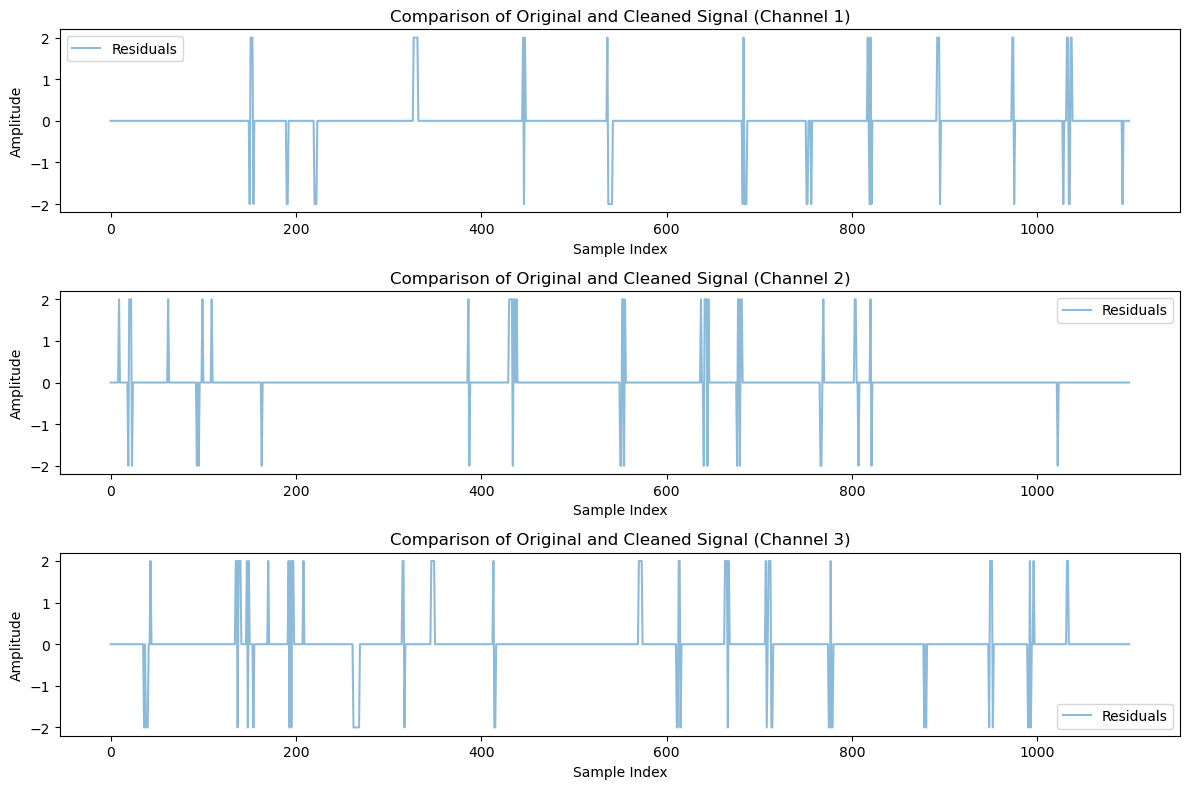

In [81]:
# Plotting the cleaned results against the original signal
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.subplot(M, 1, i + 1)
    plt.plot(signal[10000:11100] - cleaned_results[i][10000:11100], label='Residuals', alpha=0.5)
    plt.title(f'Comparison of Original and Cleaned Signal (Channel {i+1})')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

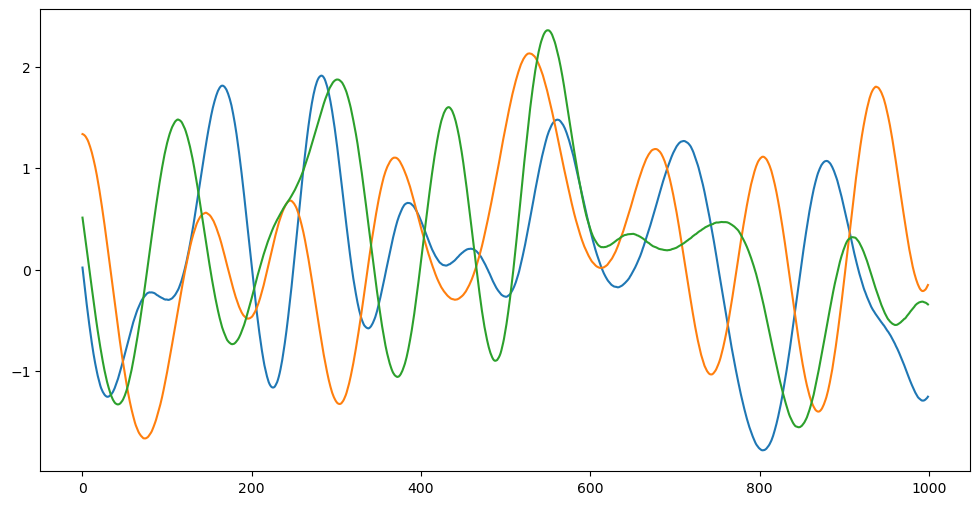

In [82]:
#Plotting the channel values together on a single plot
plt.figure(figsize = (12, 6))
for i in channel_values:
    plt.plot(i[:1000])
    

In [83]:
# Compute MSE and BER for headers alone and data bits alone
header_mse = np.zeros(M)
data_ber = np.zeros(M)

for i in range(M):
    header_mse[i] = header_error[i] / header_bit_count[i]
    total_data_bits = 0
    corrupted_data_bits = 0

    for packet_start in range(0, len(signal), packet_size):
        data_start = packet_start + int(packet_size / 2 + header_packet_size / 2)
        data_end = min(packet_start + packet_size, len(signal))
        data_bits = signal[data_start:data_end]
        cleaned_data_bits = cleaned_results[i][data_start:data_end]

        total_data_bits += len(data_bits)
        corrupted_data_bits += np.sum(data_bits != cleaned_data_bits)

    data_ber[i] = corrupted_data_bits / total_data_bits


In [84]:
# Display the results
for i in range(M):
    total_bits = len(signal)
    corrupted_bits = np.sum(signal != cleaned_results[i])
    fraction_corrupted = corrupted_bits / total_bits
    frac = header_wrong_count[i] / num[i]

    print(f'Channel {i+1}: Header MSE = {header_mse[i]:.5f}, Data BER = {data_ber[i]:.9f}')

Channel 1: Header MSE = 0.44293, Data BER = 0.053598096
Channel 2: Header MSE = 0.41921, Data BER = 0.052641404
Channel 3: Header MSE = 0.42480, Data BER = 0.049654657


In [20]:
# Lists to store results for plotting
doppler_frequencies = np.linspace(10, 300, 30)
snr_values = np.linspace(0.1, 100, 100)

mse_vs_doppler = []
ber_vs_doppler = []

mse_vs_snr = []
ber_vs_snr = []

In [21]:
# Vary Doppler frequency and compute metrics
for Fd in doppler_frequencies:
    Tc = 1 / (7 * Fd)  # Recompute coherence time based on Doppler frequency
    packet_size = math.floor(Fs*Tc)  # Recompute packet size
    header_packet_size = math.floor((1/6) * packet_size)  # Known part of the signal

    # Generate channel values using the Jakes model
    channel_values = np.array([generate_rayleigh_envelope(N, 30, Fc) for _ in range(M)])

    cleaned_results = [np.zeros(len(signal)) for _ in range(M)]
    scaled_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]
    noisy_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]

    header_error = np.zeros(M)
    header_bit_count = np.zeros(M)
    header_wrong_count = np.zeros(M)
    num = np.zeros(M)

    noise_level = 0.01  # Fixed noise level for this loop

    for packet_start in range(0, len(signal), packet_size):
        packet_end = min(packet_start + packet_size, len(signal))
        current_signal = signal[packet_start:packet_end]
        current_channel_values = channel_values[:, packet_start:packet_end]

        for i in range(M):
            scaled = current_signal * current_channel_values[i]
            average_signal_power = np.mean(scaled**2)
            var_noise = average_signal_power * noise_level
            noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
            noisy = scaled + noise
            noisy_dig = digitize(noisy)

            # Perform LS separation
            coeff, residuals, rank, s = lstsq(
                current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size].reshape(-1, 1),
                noisy_dig[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
            )
            coeff = digitize(coeff)
            cleaned_temp = noisy_dig / coeff
            cleaned = digitize(cleaned_temp)

            for channel in list(current_channel_values[i]):
                header_error[i] += (coeff - channel)**2
            header_wrong_count[i] += np.sum(
                current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size] != 
                cleaned[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
            )
            num[i] += len(current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size])
            header_bit_count[i] += len(current_channel_values[i])

            cleaned_results[i][packet_start:packet_end] = cleaned
            scaled_results[i][packet_start:packet_end] = scaled
            noisy_results[i][packet_start:packet_end] = noisy

    # Calculate metrics
    header_mse = np.zeros(M)
    data_ber = np.zeros(M)

    for i in range(M):
        header_mse[i] = header_error[i] / header_bit_count[i]
        total_data_bits = 0
        corrupted_data_bits = 0

        for packet_start in range(0, len(signal), packet_size):
            data_start = packet_start + int(packet_size / 2 + header_packet_size / 2)
            data_end = min(packet_start + packet_size, len(signal))
            data_bits = signal[data_start:data_end]
            cleaned_data_bits = cleaned_results[i][data_start:data_end]

            total_data_bits += len(data_bits)
            corrupted_data_bits += np.sum(data_bits != cleaned_data_bits)

        data_ber[i] = corrupted_data_bits / total_data_bits

    avg_header_mse = np.mean(header_mse)
    avg_data_ber = np.mean(data_ber)

    mse_vs_doppler.append(avg_header_mse)
    ber_vs_doppler.append(avg_data_ber)

In [22]:
# Vary SNR (noise level) and compute metrics
for snr in snr_values:
    noise_level = 1/snr
    Fd = 100  # Fixed Doppler frequency for this loop
    Tc = 1 / (7 * Fd)  # Recompute coherence time based on Doppler frequency
    packet_size = math.floor(Fs*Tc)  # Recompute packet size
    header_packet_size = math.floor((1/6) * packet_size)  # Known part of the signal

    # Generate channel values using the Jakes model
    channel_values = np.array([generate_rayleigh_envelope(N, 30, Fc) for _ in range(M)])

    cleaned_results = [np.zeros(len(signal)) for _ in range(M)]
    scaled_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]
    noisy_results = [np.zeros(len(signal), dtype=np.float32) for _ in range(M)]

    header_error = np.zeros(M)
    header_bit_count = np.zeros(M)
    header_wrong_count = np.zeros(M)
    num = np.zeros(M)

    for packet_start in range(0, len(signal), packet_size):
        packet_end = min(packet_start + packet_size, len(signal))
        current_signal = signal[packet_start:packet_end]
        current_channel_values = channel_values[:, packet_start:packet_end]

        for i in range(M):
            scaled = current_signal * current_channel_values[i]
            average_signal_power = np.mean(scaled**2)
            var_noise = average_signal_power * noise_level
            noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
            noisy = scaled + noise
            noisy_dig = digitize(noisy)

            # Perform LS separation
            coeff, residuals, rank, s = lstsq(
                current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size].reshape(-1, 1),
                noisy_dig[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
            )
            coeff = digitize(coeff)
            cleaned_temp = noisy_dig / coeff
            cleaned = digitize(cleaned_temp)

            for channel in list(current_channel_values[i]):
                header_error[i] += (coeff - channel)**2
            header_wrong_count[i] += np.sum(
                current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size] != 
                cleaned[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size]
            )
            num[i] += len(current_signal[int(packet_size/2 - header_packet_size/2):int(packet_size/2 - header_packet_size/2) + header_packet_size])
            header_bit_count[i] += len(current_channel_values[i])

            cleaned_results[i][packet_start:packet_end] = cleaned
            scaled_results[i][packet_start:packet_end] = scaled
            noisy_results[i][packet_start:packet_end] = noisy

    # Calculate metrics
    header_mse = np.zeros(M)
    data_ber = np.zeros(M)

    for i in range(M):
        header_mse[i] = header_error[i] / header_bit_count[i]
        total_data_bits = 0
        corrupted_data_bits = 0

        for packet_start in range(0, len(signal), packet_size):
            data_start = packet_start + int(packet_size / 2 + header_packet_size / 2)
            data_end = min(packet_start + packet_size, len(signal))
            data_bits = signal[data_start:data_end]
            cleaned_data_bits = cleaned_results[i][data_start:data_end]

            total_data_bits += len(data_bits)
            corrupted_data_bits += np.sum(data_bits != cleaned_data_bits)

        data_ber[i] = corrupted_data_bits / total_data_bits

    avg_header_mse = np.mean(header_mse)
    avg_data_ber = np.mean(data_ber)

    mse_vs_snr.append(avg_header_mse)
    ber_vs_snr.append(avg_data_ber)

In [2]:
# Plot MSE and BER vs Doppler Frequency
plt.figure(figsize=(14, 6))
plt.plot(10*np.log10(doppler_frequencies), 10*np.log10(mse_vs_doppler), 'o-', label='MSE vs Doppler')
plt.plot(10*np.log10(doppler_frequencies), 10*np.log10(ber_vs_doppler), 's-', label='BER vs Doppler')
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('MSE/BER')
plt.legend()
plt.title('MSE and BER vs Doppler Frequency')


NameError: name 'plt' is not defined

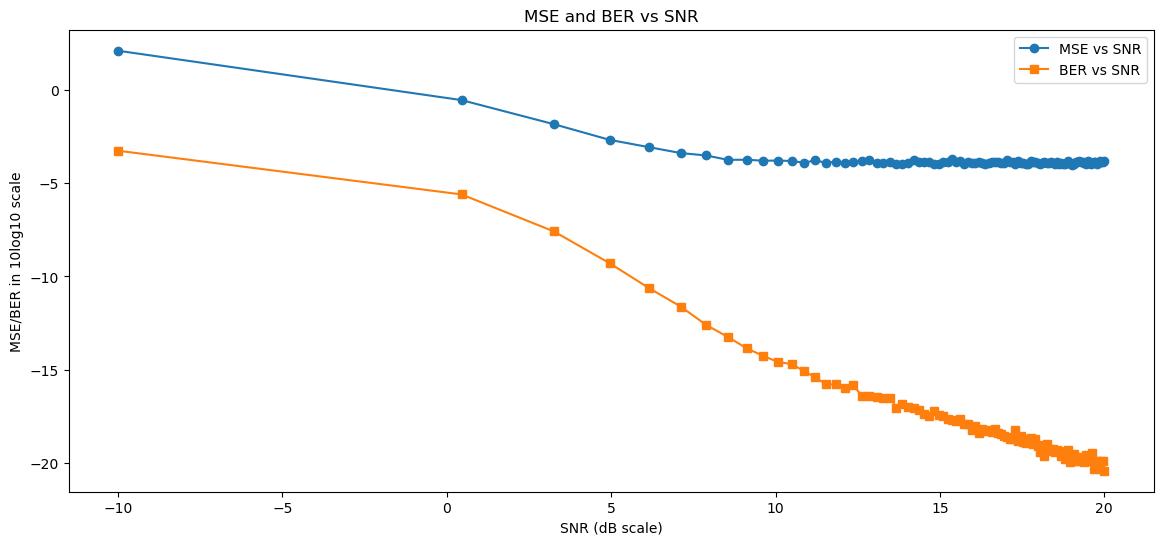

In [46]:
# Plot MSE and BER vs SNR
plt.figure(figsize=(14, 6))
plt.plot(10*np.log10(snr_values), 10*np.log10(mse_vs_snr), 'o-', label='MSE vs SNR')
plt.plot(10*np.log10(snr_values), 10*np.log10(ber_vs_snr), 's-', label='BER vs SNR')
plt.xlabel('SNR (dB scale)')
plt.ylabel('MSE/BER in 10log10 scale')
plt.legend()
plt.title('MSE and BER vs SNR')
plt.show()